# Problem Statement

- Classify movies into 3 classes - 'Rotten', 'Fresh' or 'Certified-Fresh'\
- Criteria is as follows:
    - Fresh: Tomatometer score >= 60%
    - Rotten: Tomatometer score < 60%
    - Certified-Fresh:
        - A consistent tomatometer score of at least 75% **and**
        - At least 5 reviews from top critics **and**
        - A minimum of 80 reviews for films in wide release

- We will use 2 approaches:
    1. Predict movie status based on **numerical and categorical features**.
    2. Predict movie status based on **Review Sentiment**

- We will use:
    - Decision Tree Classifier
    - Random Forest Algorithm



# 1. Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
df_movie = pd.read_csv('rotten_tomatoes_movies.csv')
df_movie.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3


In [3]:
df_movie.describe() # gives the description of the numerical features

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
count,17398.000000,17668.000000,17668.000000,17416.000000,1.741500e+04,17712.000000,17712.000000,17712.000000
mean,102.214048,60.884763,57.139801,60.554260,1.439401e+05,14.586326,36.374831,20.703139
std,18.702511,28.443348,68.370047,20.543369,1.763577e+06,15.146349,52.601038,30.248435
min,5.000000,0.000000,5.000000,0.000000,5.000000e+00,0.000000,0.000000,0.000000
25%,90.000000,38.000000,12.000000,45.000000,7.075000e+02,3.000000,6.000000,3.000000
50%,99.000000,67.000000,28.000000,63.000000,4.277000e+03,8.000000,16.000000,8.000000
75%,111.000000,86.000000,75.000000,78.000000,2.498800e+04,23.000000,44.000000,24.000000
max,266.000000,100.000000,574.000000,100.000000,3.579764e+07,69.000000,497.000000,303.000000


- We have a large number of numerical features.
- Our target variable is `tomatometer_status`
- It is important to note that features have missing values, we need to deal with.

Content Rating category: ['PG' 'R' 'NR' 'G' 'PG-13' 'NC17']


[Text(0, 0, '6377'),
 Text(0, 0, '5474'),
 Text(0, 0, '2979'),
 Text(0, 0, '2168'),
 Text(0, 0, '676'),
 Text(0, 0, '38')]

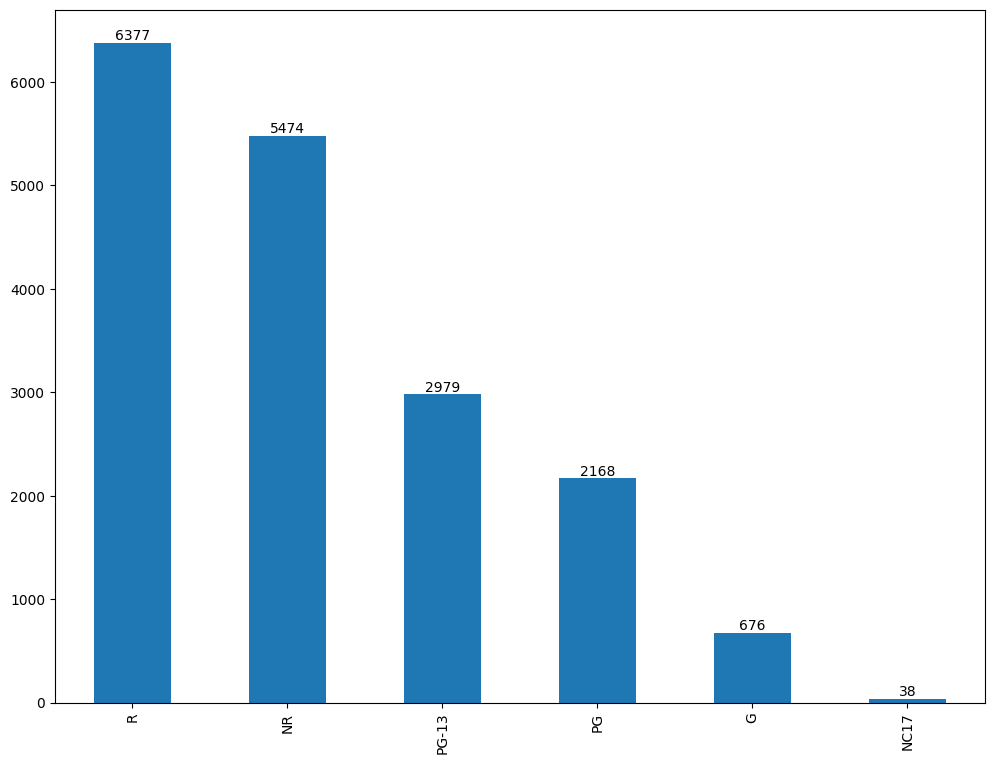

In [4]:
# Visualizing content rating
print(f'Content Rating category: {df_movie.content_rating.unique()}')

ax = df_movie['content_rating'].value_counts().plot(kind='bar', figsize=(12,9))
ax.bar_label(ax.containers[0])

- Need to convert this feature into numerical representations
- Two popular methods: **ordinal encoding** and **one-hot encoding**
### Ordinal Encoding
It is used when the categorical feature represents a degree of magnitude (think S, M, L).
### One Hot Encoding
It is used when one value is not more important than other values in a categorical feature.

In [5]:
# one-hot encoding the content rating feature
content_rating = pd.get_dummies(df_movie['content_rating'])
content_rating.head()

,G,NC17,NR,PG,PG-13,R
0,0,0,0,1,0,0
1,0,0,0,0,0,1
2,0,0,0,0,0,1
3,0,0,1,0,0,0
4,1,0,0,0,0,0


- Audience Status has the values 'Spilled' and 'Upright'.
- It needs ordinal encoding.

Audience Status Category: ['Spilled' 'Upright' nan]


[Text(0, 0, '9390'), Text(0, 0, '7874')]

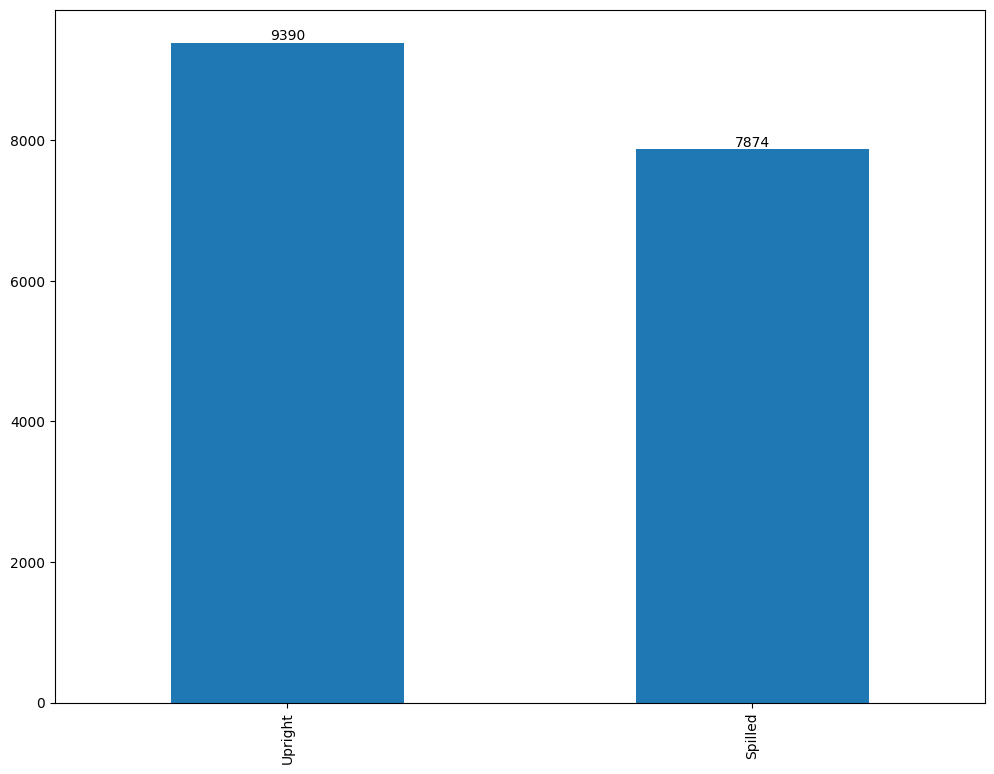

In [6]:
print(f'Audience Status Category: {df_movie.audience_status.unique()}')

ax = df_movie.audience_status.value_counts().plot(kind='bar', figsize=(12,9))
ax.bar_label(ax.containers[0])

In [7]:
# ordinal coding for audience status
audience_status = pd.DataFrame(df_movie.audience_status.replace(['Spilled', 'Upright'], [0,1]))
audience_status.head()

,audience_status
0,0.0
1,1.0
2,0.0
3,1.0
4,1.0


**Note: You can use the `.replace()` method in pandas DataFrame to encode categorical values of a feature into numerical values**

In [8]:
# Encode tomatometer status with ordinal encoding
tomatometer_status = pd.DataFrame(df_movie.tomatometer_status.replace(['Rotten', 'Fresh', 'Certified-Fresh'], [0,1,2]))
tomatometer_status.head()

,tomatometer_status
0,0.0
1,2.0
2,1.0
3,2.0
4,1.0


In [12]:
# Combine all features into one dataframe. Drop NULL values
df_feature = pd.concat([df_movie[['runtime', 'tomatometer_rating', 'tomatometer_count', 'audience_rating', 'audience_count', \
    'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count']], \
        content_rating, audience_status, tomatometer_status], axis=1).dropna()
df_feature.head()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,G,NC17,NR,PG,PG-13,R,audience_status,tomatometer_status
0,119.0,49.0,149.0,53.0,254421.0,43,73,76,0,0,0,1,0,0,0.0,0.0
1,90.0,87.0,142.0,64.0,11574.0,44,123,19,0,0,0,0,0,1,1.0,2.0
2,122.0,67.0,24.0,53.0,14684.0,2,16,8,0,0,0,0,0,1,0.0,1.0
3,95.0,100.0,54.0,97.0,105386.0,6,54,0,0,0,1,0,0,0,1.0,2.0
4,127.0,89.0,27.0,74.0,68918.0,5,24,3,1,0,0,0,0,0,1.0,1.0


In [13]:
df_feature.describe().T

,count,mean,std,min,25%,50%,75%,max
runtime,17017.0,102.296233,1.865365e+01,5.0,90.0,99.0,111.0,266.0
tomatometer_rating,17017.0,60.519539,2.843640e+01,0.0,38.0,66.0,86.0,100.0
tomatometer_count,17017.0,57.097197,6.681458e+01,5.0,12.0,29.0,76.0,535.0
audience_rating,17017.0,60.324499,2.048060e+01,0.0,44.0,62.0,77.0,100.0
audience_count,17017.0,147118.274843,1.783955e+06,5.0,741.0,4423.0,26067.0,35797635.0
tomatometer_top_critics_count,17017.0,14.765999,1.517226e+01,0.0,3.0,8.0,23.0,69.0
tomatometer_fresh_critics_count,17017.0,36.237292,5.136245e+01,0.0,6.0,17.0,44.0,497.0
tomatometer_rotten_critics_count,17017.0,20.871188,2.997890e+01,0.0,3.0,8.0,24.0,303.0
G,17017.0,0.039314,1.943458e-01,0.0,0.0,0.0,0.0,1.0
NC17,17017.0,0.002174,4.658000e-02,0.0,0.0,0.0,0.0,1.0


[Text(0, 0, '7375'), Text(0, 0, '6475'), Text(0, 0, '3167')]

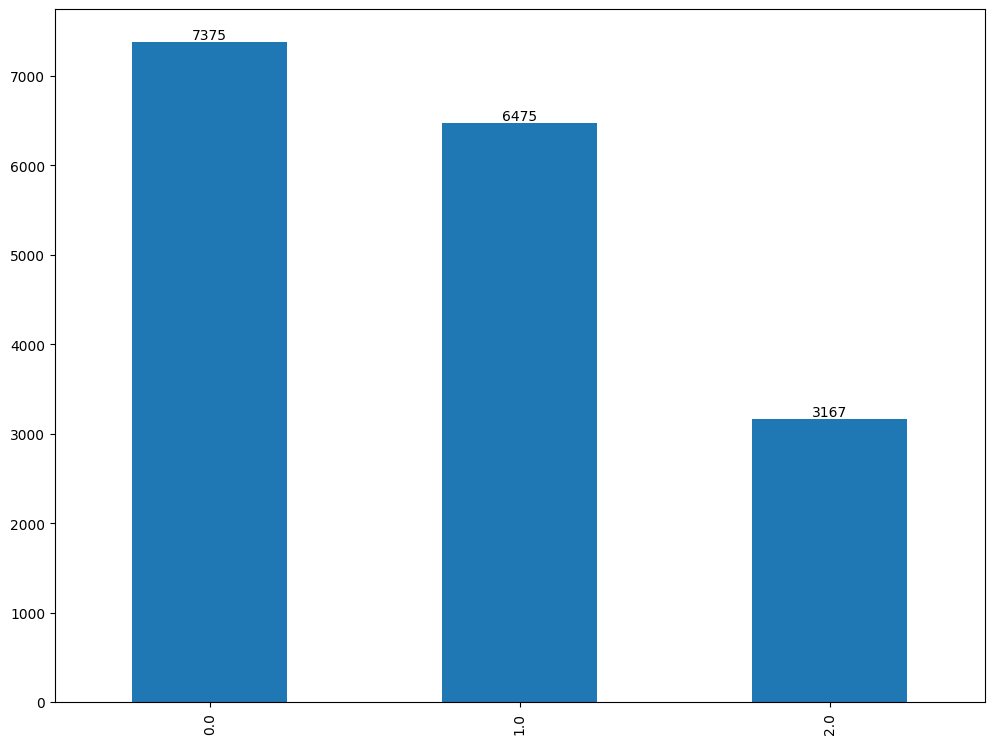

In [15]:
# Get the distribution of the target variable
ax = df_feature.tomatometer_status.value_counts().plot(kind='bar', figsize=(12,9))
ax.bar_label(ax.containers[0])

We have a class imbalance problem, need to address this later.

- Let us now create train and test splits of the dataset.

In [16]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_feature.drop(['tomatometer_status'], axis=1), \
    df_feature['tomatometer_status'], test_size=0.2, random_state=42)

print(f'Size of training data is {len(X_train)} and the size of the test data is {len(X_test)}')

Size of training data is 13613 and the size of the test data is 3404


# Decision Tree Classifier
- Constrained to 3 leaf nodes because we have 3 classes

0.9462397179788484
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.97      0.88      0.93      1286
         2.0       0.80      0.95      0.87       630

    accuracy                           0.95      3404
   macro avg       0.92      0.94      0.93      3404
weighted avg       0.95      0.95      0.95      3404



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


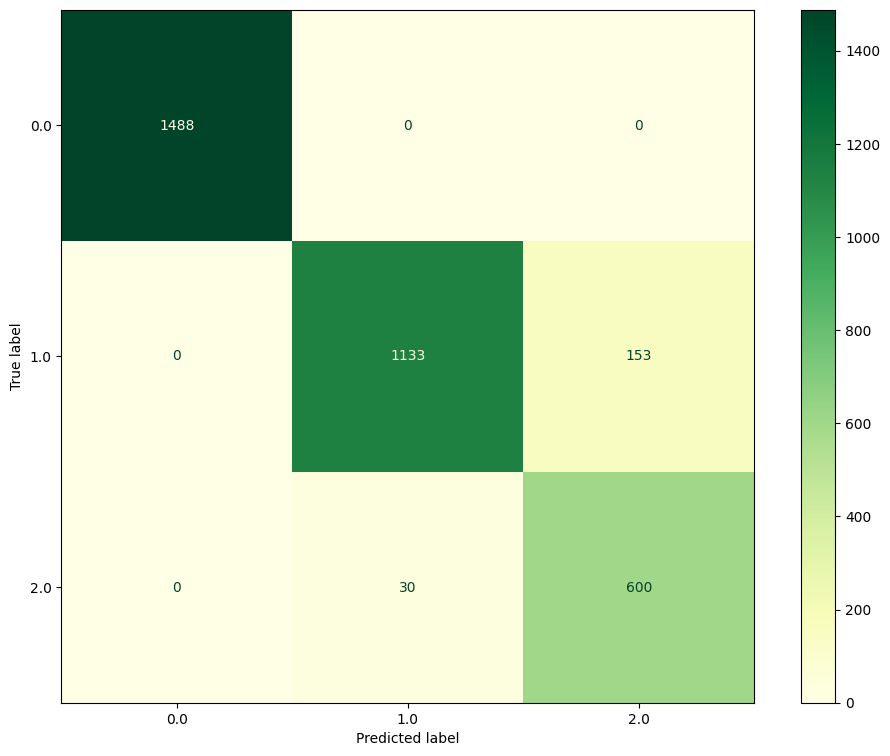

In [33]:
# Initialize the tree classifier
tree_3_leaf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=2)

# Train the classifier on training data
tree_3_leaf.fit(X_train, y_train)

# Predict the test data with the trained model
y_predict = tree_3_leaf.predict(X_test)

# Print accuracy and classification report on test data
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

# Plot confusion matrix on test data
fig, ax = plt.subplots(figsize=(12,9))
plot_confusion_matrix(tree_3_leaf, X_test, y_test, cmap = 'YlGn', ax=ax)


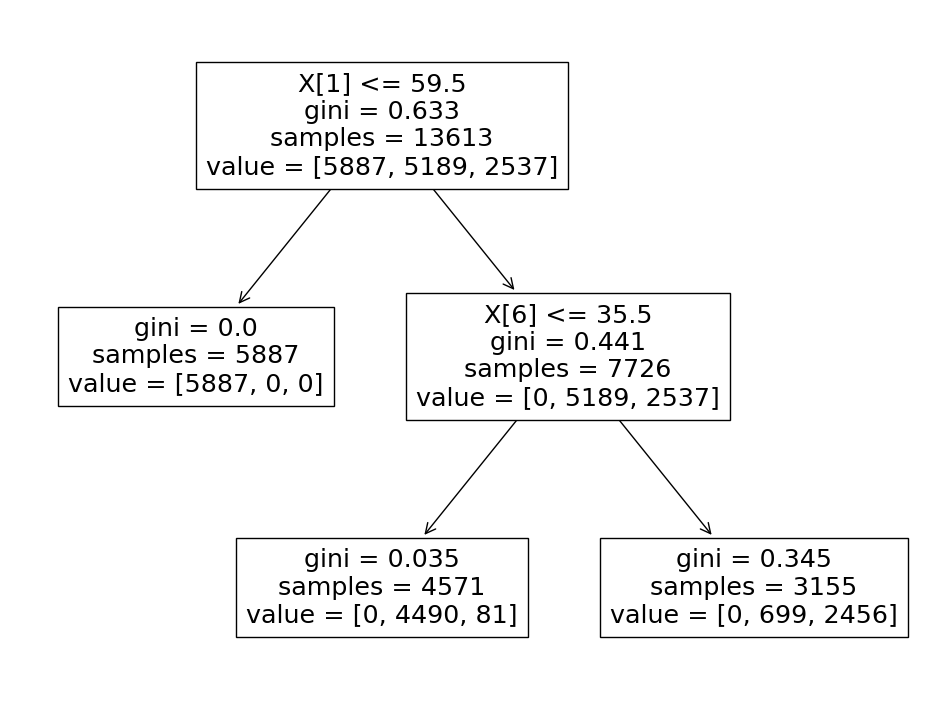

In [34]:
# Visualize the decision logic of the decision tree model

fig, ax = plt.subplots(figsize=(12,9))
plot_tree(tree_3_leaf, ax=ax)
plt.show()

- X[1] is the `tomatometer_rating` feature
- X[6] is the `tomatometer_fresh_critics_count` feature

# Decision Tree Unconstrained

0.9900117508813161
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.99      0.99      0.99      1286
         2.0       0.97      0.97      0.97       630

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


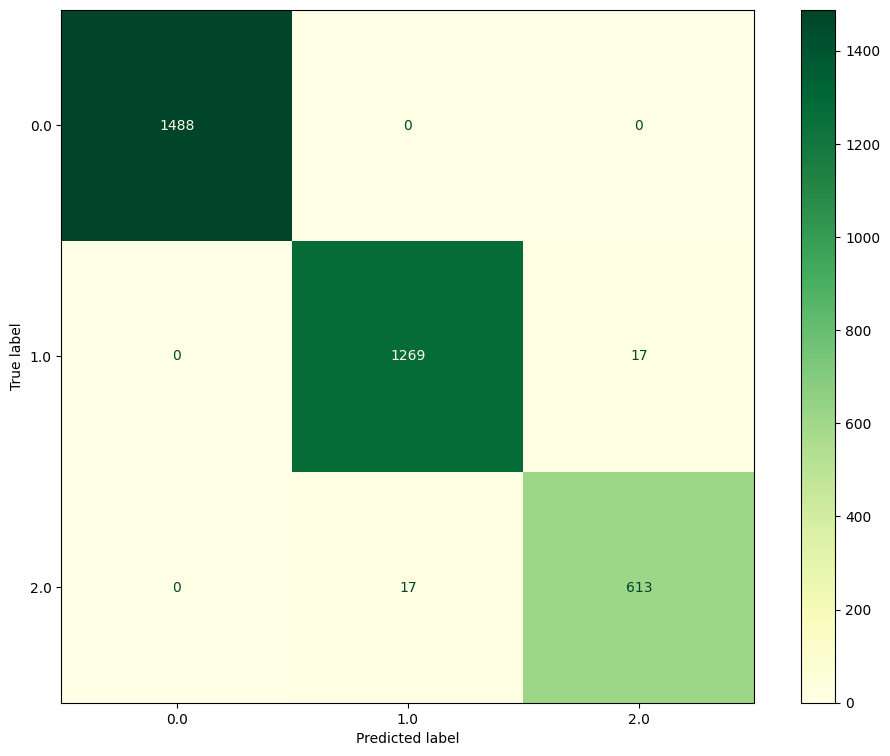

In [35]:
#Instantiate
tree = DecisionTreeClassifier(random_state=2)

# Train
tree.fit(X_train, y_train)

# Predict
y_predict = tree.predict(X_test)

# Print accuracy
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

# Print confusion matrix
fig, ax = plt.subplots(figsize=(12,9))
plot_confusion_matrix(tree, X_test, y_test, cmap = 'YlGn', ax=ax)

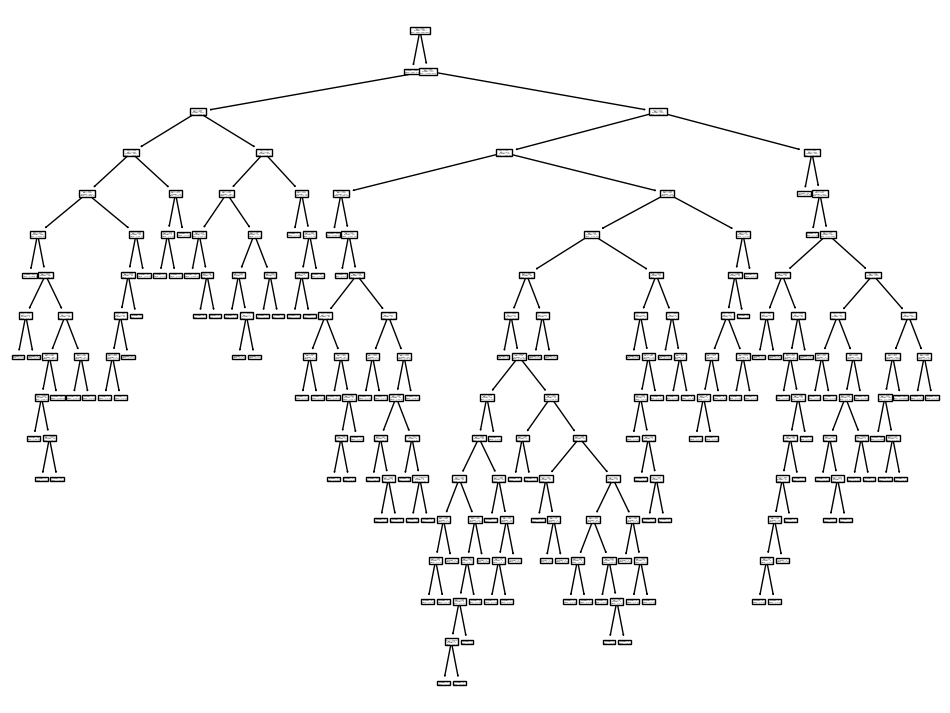

In [36]:
# Visualize the decision logic of the decision tree model

fig, ax = plt.subplots(figsize=(12,9))
plot_tree(tree, ax=ax)
plt.show()

> Looks like the number of leaf nodes constraint isn't related to the number of final classes we have

# Random Forest Classifier

0.9908930669800236
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.99      0.99      0.99      1286
         2.0       0.98      0.97      0.98       630

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


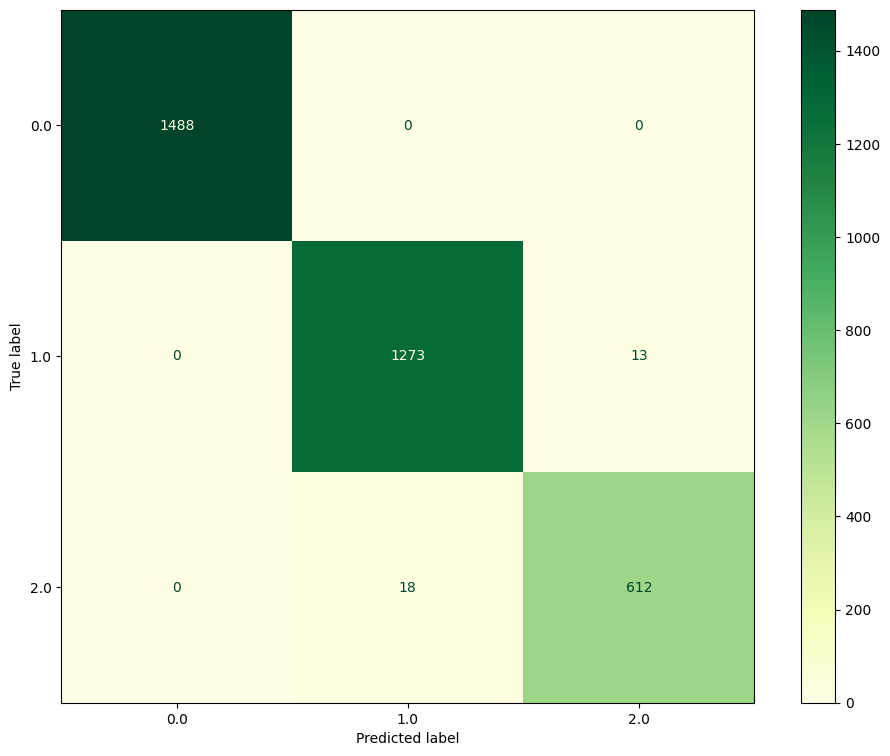

In [37]:
# Instantiate
rf = RandomForestClassifier(random_state=2)

# Train
rf.fit(X_train, y_train)

# Predict
y_predict = rf.predict(X_test)

# Print accuracy score and classification report
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(12,9))
plot_confusion_matrix(rf, X_test, y_test, cmap = 'YlGn', ax=ax)



# Visualizing feature importances
- Let's see if we can improve the performance of this model by eliminating features that don't contribute to the classification

runtime = 0.0061295693480302215
tomatometer_rating = 0.4751025864067028
tomatometer_count = 0.09895425717250429
audience_rating = 0.05389101976402856
audience_count = 0.016289896938110955
tomatometer_top_critics_count = 0.03605739578773787
tomatometer_fresh_critics_count = 0.14158242877024638
tomatometer_rotten_critics_count = 0.1314030539462201
G = 0.00029824734631526663
NC17 = 1.7090610669550172e-05
NR = 0.008710731204885382
PG = 0.0005762363713202383
PG-13 = 0.002531466583040527
R = 0.0022318936876928337
audience_status = 0.026224126062495294


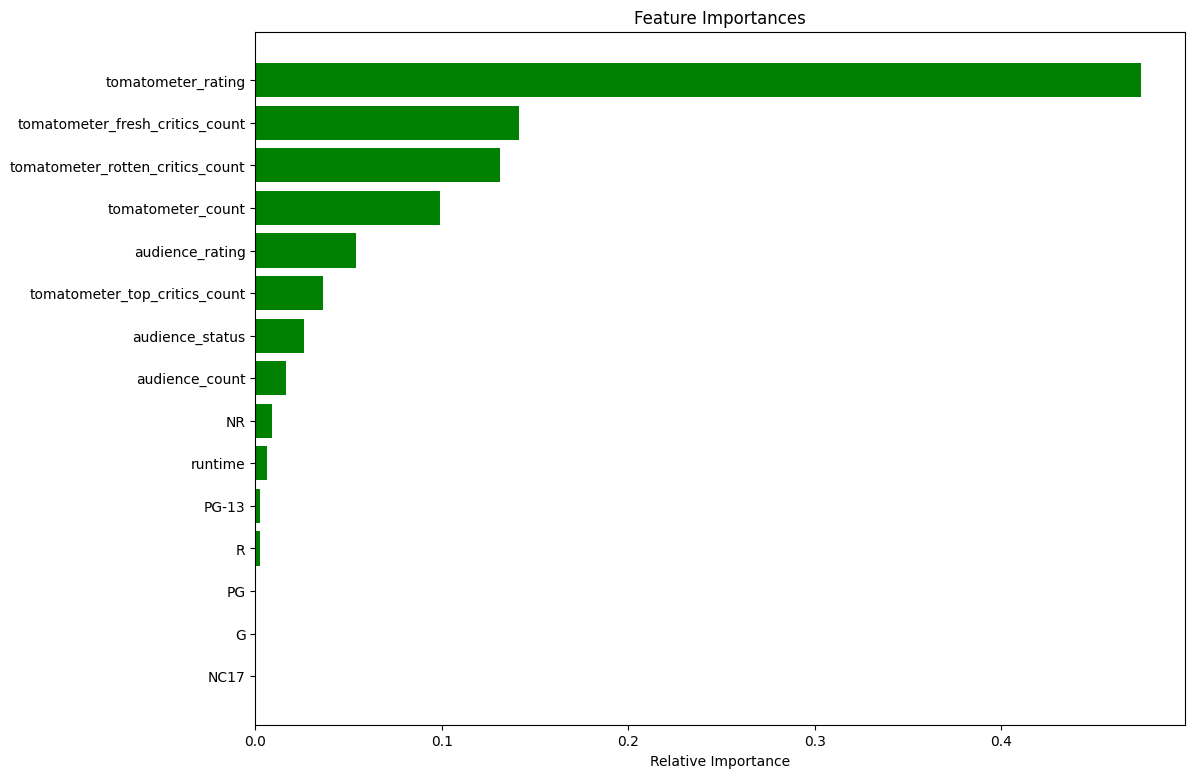

In [38]:
# Get feature importance
feature_importance = rf.feature_importances_

# Print feature importance
for i, feature in enumerate(X_train.columns):
    print(f'{feature} = {feature_importance[i]}')

# Visualize feature from the most important to least important
indices = np.argsort(feature_importance)

plt.figure(figsize=(12,9))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importance[indices], color='g', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- We can see that runtime and movie category rating (NR, PG-13 etc.) are not important
- So, we'll drop them and build a Random Forest Classifier


# Random Forest Classifier with Feature Selection

In [41]:
# Do feature selection and split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_feature.drop(['tomatometer_status', 'NR', 'runtime', 'PG-13', 'R', \
    'PG', 'G', 'NC17'], axis=1), df_feature['tomatometer_status'], test_size=0.2, random_state=42)

print(f'Size of training data is {X_train.shape} and size of test data is {X_test.shape}')

Size of training data is (13613, 8) and size of test data is (3404, 8)


0.9917743830787309
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.99      0.99      0.99      1286
         2.0       0.98      0.97      0.98       630

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


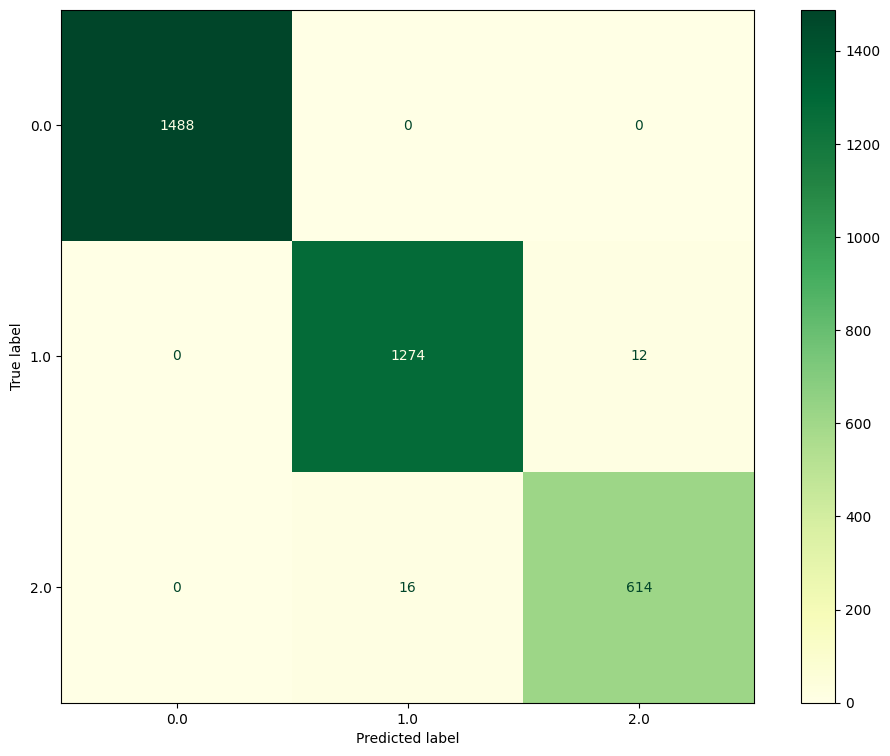

In [42]:
# Instantiate
rf = RandomForestClassifier(random_state=2)

# Train
rf.fit(X_train, y_train)

# Predict
y_predict = rf.predict(X_test)

# Print accuracy and classification report
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12,9))
plot_confusion_matrix(rf, X_test, y_test, cmap = 'YlGn', ax=ax)

# Weighted Random Forest Classifier with Feature Selection

- We will weight the classes according to the number of their occurences

In [45]:
# Calculate class weights
class_weight = compute_class_weight(class_weight='balanced', classes = np.unique(df_feature['tomatometer_status']), \
    y = df_feature['tomatometer_status'].values)

class_weight_dict = dict(zip(range(len(class_weight.tolist())), class_weight.tolist()))
class_weight_dict

{0: 0.7691299435028248, 1: 0.8760360360360361, 2: 1.7910746237238186}

0.9926556991774383
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.99      0.99      0.99      1286
         2.0       0.98      0.98      0.98       630

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


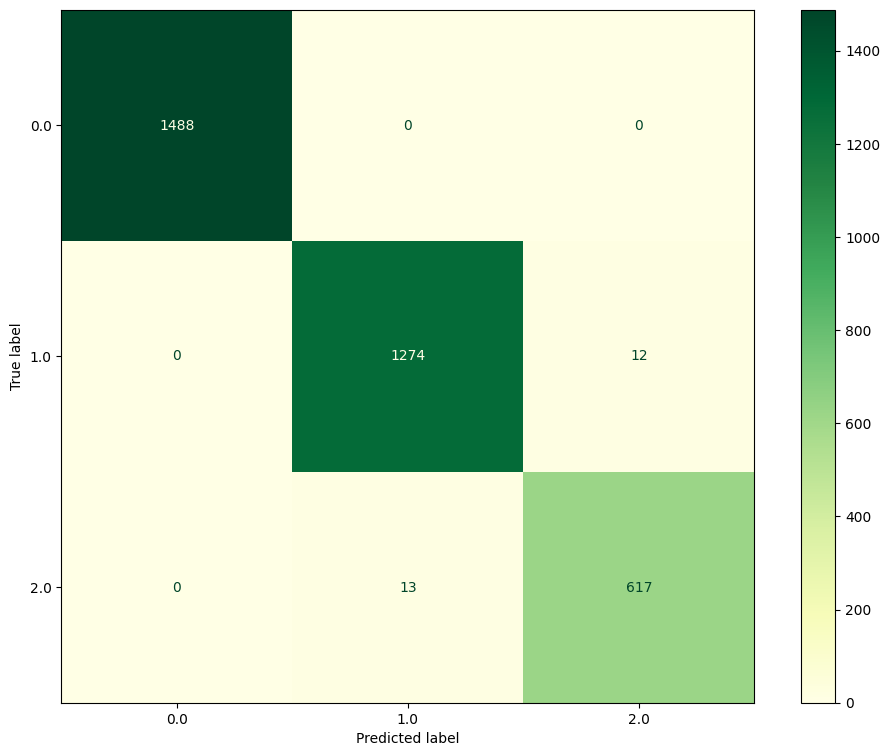

In [49]:
# Instantiate
rf_weighted = RandomForestClassifier(random_state=2, class_weight=class_weight_dict)

# Train
rf_weighted.fit(X_train, y_train)

# Predict
y_predict = rf_weighted.predict(X_test)

# Print accuracy score and classification report
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(12,9))
plot_confusion_matrix(rf_weighted, X_test, y_test, cmap = 'YlGn', ax=ax)